In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
words = open("names.txt", 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3 
def build_dataset(words):  
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] 
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [6]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])   
Xdev, Ydev = build_dataset(words[n1:n2])  
Xte,  Yte  = build_dataset(words[n2:])  

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## MLP Review


In [7]:
# good ones, the naive one is followed later
n_embd = 10 
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden, generator=g) 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
# make it small, but not 0
# b2 = torch.randn(vocab_size, generator=g)
b2 = torch.randn(vocab_size, generator=g) * 0

# baatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [8]:
Xtr.shape

torch.Size([182625, 3])

In [9]:
max_steps = 20000
batch_size = 32
lossi = []

In [10]:

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # linear layer
    # hidden layer pre-activation
    hpreact = embcat @ W1 #+ b1 
    
    
    # BatchNorm layer
    # -------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    
    
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)
    

    for p in parameters:
        p.grad = None
    loss.backward()


    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 100 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
  

      0/  20000: 3.3147
    100/  20000: 2.4222
    200/  20000: 2.8362
    300/  20000: 2.5838
    400/  20000: 2.5099
    500/  20000: 2.7987
    600/  20000: 2.4470
    700/  20000: 2.4766
    800/  20000: 2.3610
    900/  20000: 2.1361
   1000/  20000: 2.1945
   1100/  20000: 2.2817
   1200/  20000: 2.6710
   1300/  20000: 2.7380
   1400/  20000: 2.3078
   1500/  20000: 2.3958
   1600/  20000: 2.6015
   1700/  20000: 2.3745
   1800/  20000: 2.3172
   1900/  20000: 2.3646
   2000/  20000: 2.3061
   2100/  20000: 2.4367
   2200/  20000: 1.9582
   2300/  20000: 2.4397
   2400/  20000: 2.8702
   2500/  20000: 2.3725
   2600/  20000: 2.3520
   2700/  20000: 2.1794
   2800/  20000: 2.2166
   2900/  20000: 2.2390
   3000/  20000: 2.2337
   3100/  20000: 2.5820
   3200/  20000: 2.2044
   3300/  20000: 2.2671
   3400/  20000: 2.2901
   3500/  20000: 2.4187
   3600/  20000: 2.0603
   3700/  20000: 2.1360
   3800/  20000: 2.3896
   3900/  20000: 2.3852
   4000/  20000: 2.1661
   4100/  20000:

In [11]:
hpreact.shape, h.shape

(torch.Size([32, 200]), torch.Size([32, 200]))

In [12]:
hpreact.view(-1).tolist()[:10]

[0.7554177045822144,
 -0.21455660462379456,
 0.7001316547393799,
 0.38432154059410095,
 0.5316116809844971,
 1.7487071752548218,
 -1.0339550971984863,
 -0.712029218673706,
 -0.24147823452949524,
 -0.17615535855293274]

In [13]:
h.view(-1).tolist()[:10]

[0.6383699774742126,
 -0.2113237828016281,
 0.6044513583183289,
 0.3664545714855194,
 0.48661211133003235,
 0.9412282109260559,
 -0.7754897475242615,
 -0.6119477152824402,
 -0.23689152300357819,
 -0.1743556261062622]

(array([244., 204., 182., 167., 161., 126., 140., 118., 141., 118., 111.,
        131., 126., 104., 126., 110., 108.,  96., 120., 127.,  97., 103.,
         94., 120.,  97.,  88., 109.,  90.,  96.,  99., 103., 101., 100.,
         83., 103.,  99., 106., 114., 126., 135., 142., 113., 138., 161.,
        138., 123., 181., 153., 202., 226.]),
 array([-9.99714553e-01, -9.59725318e-01, -9.19736083e-01, -8.79746847e-01,
        -8.39757612e-01, -7.99768376e-01, -7.59779141e-01, -7.19789906e-01,
        -6.79800670e-01, -6.39811435e-01, -5.99822199e-01, -5.59832964e-01,
        -5.19843729e-01, -4.79854493e-01, -4.39865258e-01, -3.99876022e-01,
        -3.59886787e-01, -3.19897552e-01, -2.79908316e-01, -2.39919081e-01,
        -1.99929845e-01, -1.59940610e-01, -1.19951375e-01, -7.99621391e-02,
        -3.99729037e-02,  1.63316727e-05,  4.00055671e-02,  7.99948025e-02,
         1.19984038e-01,  1.59973273e-01,  1.99962509e-01,  2.39951744e-01,
         2.79940979e-01,  3.19930215e-01,  3.59919

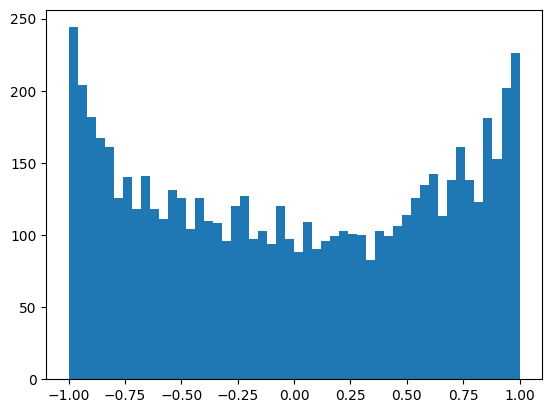

In [14]:
plt.hist(h.view(-1).tolist(), 50)
# in tanh, everything is being "squashed and rearranged"

(array([  3.,   0.,   0.,   1.,   2.,   5.,   2.,   7.,  11.,  16.,  27.,
         49.,  49.,  81.,  96., 116., 142., 192., 239., 252., 330., 382.,
        422., 469., 440., 432., 392., 381., 386., 314., 277., 197., 173.,
        124., 104.,  89.,  56.,  54.,  27.,  20.,  13.,   4.,  10.,   7.,
          2.,   2.,   1.,   1.,   0.,   1.]),
 array([-4.42725611, -4.24895202, -4.07064793, -3.89234384, -3.71403975,
        -3.53573565, -3.35743156, -3.17912747, -3.00082338, -2.82251929,
        -2.6442152 , -2.46591111, -2.28760702, -2.10930293, -1.93099884,
        -1.75269475, -1.57439066, -1.39608657, -1.21778248, -1.03947839,
        -0.8611743 , -0.68287021, -0.50456612, -0.32626203, -0.14795794,
         0.03034616,  0.20865025,  0.38695434,  0.56525843,  0.74356252,
         0.92186661,  1.1001707 ,  1.27847479,  1.45677888,  1.63508297,
         1.81338706,  1.99169115,  2.16999524,  2.34829933,  2.52660342,
         2.70490751,  2.8832116 ,  3.06151569,  3.23981978,  3.41812387,
 

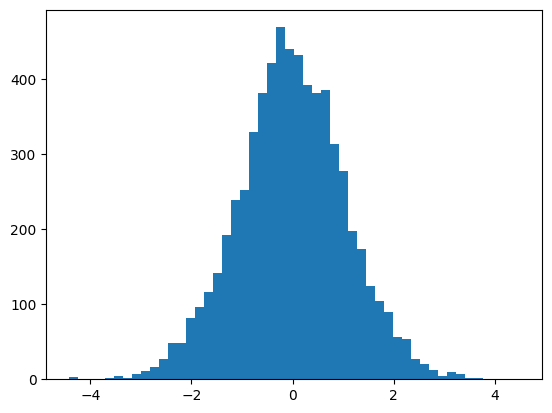

In [15]:
plt.hist(hpreact.view(-1).tolist()[:10000], 50)

# hpreact is only -4 to 4, better than the worse/latter version

In [16]:
# seperate stuff
# 1/27 initial chance of being chosen for any character
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [17]:
# seperate stuff

logits = torch.randn(4)
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log()
logits, probs, loss

# therefore, things could have gone wrong if the first losses are much higher than 3.2958

(tensor([0.4227, 1.1018, 0.7657, 0.2971]),
 tensor([0.1900, 0.3747, 0.2677, 0.1676]),
 tensor(1.3178))

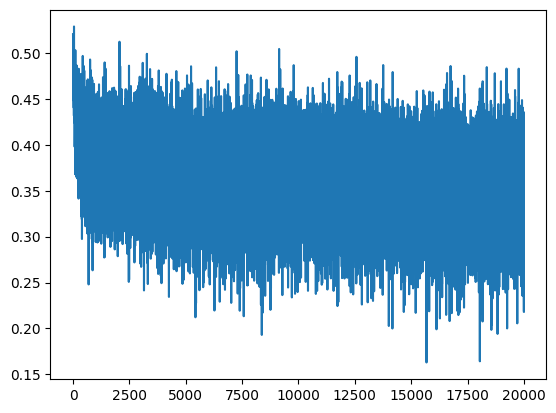

In [18]:
plt.plot(lossi)

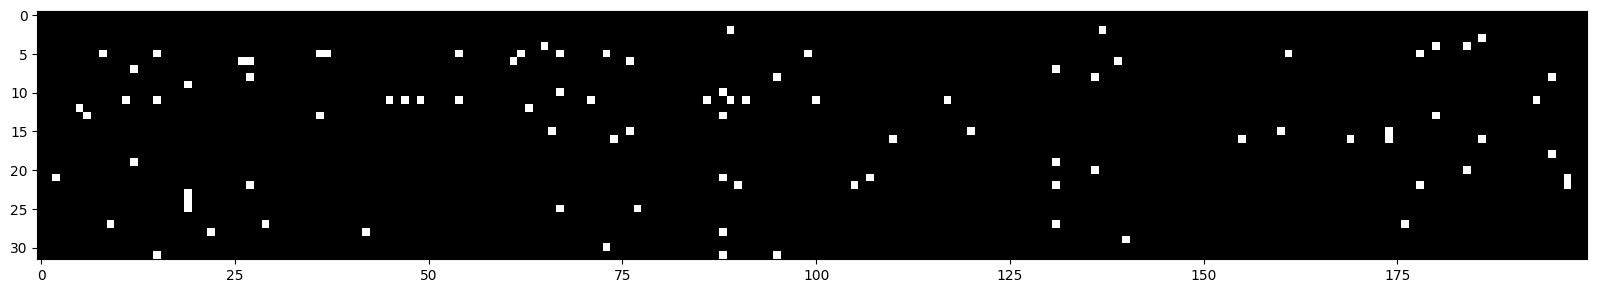

In [19]:
plt.figure(figsize = (20, 10))
plt.imshow(h.abs()>0.99, cmap = 'gray', interpolation = "nearest")
# if it is a white dot, it means that dot is near the tail and has been activated. 
# a column is all white, it is a dead neuron. 
# choosing 0.99 here, because it means towards the tail,  
# if a nueron gets the result in the tails, for the flat part of an activation, it is inactive afterwards... 
# it does not have gradient pass through, and it probably will never be reactivated again in the future. sooo... 
# it is kind of like brain damage.
# we should avoid this kind of gradient 

In [20]:
# MLP revisited
# worse version

# a worse version, b1, b1, b2, w2 are not close to 0
# the first loss is going to be huge


n_embd = 10 
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g) 
W2 = torch.randn((n_hidden, vocab_size), generator=g) 
# make it small, but not 0
# b2 = torch.randn(vocab_size, generator=g)
b2 = torch.randn(vocab_size, generator=g) 

# baatchNorm parameters
# bngain = torch.ones((1, n_hidden))
# bnbias = torch.zeros((1, n_hidden))
# bnmean_running = torch.zeros((1, n_hidden))
# bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2,]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [21]:
for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # linear layer
    # hidden layer pre-activation
    hpreact = embcat @ W1 + b1 
    
    
    # BatchNorm layer
    # -------------------------------------------------------
#     bnmeani = hpreact.mean(0, keepdim=True)
#     bnstdi = hpreact.std(0, keepdim=True)
#     hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    
    
#     with torch.no_grad():
#         bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
#         bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
#     # -------------------------------------------
#     # Non-linearity
#     h = torch.tanh(hpreact) 
#     logits = h @ W2 + b2 
#     loss = F.cross_entropy(logits, Yb)
    

    for p in parameters:
        p.grad = None
    loss.backward()


    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 200 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
  

      0/  20000: 27.8817
    200/  20000: 8.7435
    400/  20000: 3.6911
    600/  20000: 4.2153
    800/  20000: 5.2333
   1000/  20000: 4.0903
   1200/  20000: 4.0933
   1400/  20000: 3.1122
   1600/  20000: 3.7591
   1800/  20000: 3.4161
   2000/  20000: 2.9773
   2200/  20000: 2.6979
   2400/  20000: 3.5182
   2600/  20000: 3.0858
   2800/  20000: 3.0245
   3000/  20000: 2.9625
   3200/  20000: 2.7569
   3400/  20000: 3.0178
   3600/  20000: 2.5338
   3800/  20000: 2.7519
   4000/  20000: 2.3263
   4200/  20000: 2.9018
   4400/  20000: 2.5059
   4600/  20000: 2.2889
   4800/  20000: 2.7963
   5000/  20000: 2.3998
   5200/  20000: 2.9633
   5400/  20000: 3.1338
   5600/  20000: 3.3486
   5800/  20000: 2.6856
   6000/  20000: 2.3728
   6200/  20000: 3.3100
   6400/  20000: 3.0872
   6600/  20000: 2.9549
   6800/  20000: 2.7653
   7000/  20000: 2.7671
   7200/  20000: 2.2756
   7400/  20000: 2.2455
   7600/  20000: 3.0820
   7800/  20000: 2.1984
   8000/  20000: 2.4620
   8200/  20000

(array([2081.,  230.,  143.,  100.,   47.,   37.,   45.,   27.,   41.,
          28.,   19.,   17.,   22.,   23.,   20.,   15.,   24.,   16.,
          15.,   22.,   14.,   16.,   18.,   13.,   16.,   14.,   17.,
          22.,   10.,   11.,   13.,   15.,   24.,   18.,   19.,   20.,
          18.,   14.,   34.,   22.,   21.,   26.,   40.,   42.,   52.,
          70.,   65.,  108.,  253., 2403.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

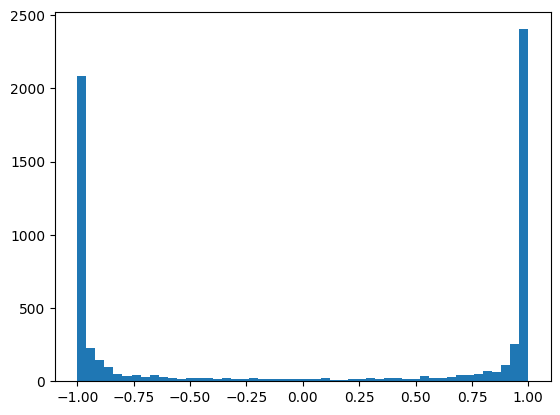

In [22]:
# h data is very extreme
plt.hist(h.view(-1).tolist(), 50)
# in tanh, everything is being "squashed and rearranged"

(array([  1.,   0.,   1.,   3.,   6.,   5.,  10.,  15.,  28.,  40.,  39.,
         65.,  86., 102., 140., 160., 198., 245., 316., 406., 413., 387.,
        273., 264., 288., 372., 429., 344., 272., 322., 284., 208., 188.,
        130., 114.,  72.,  55.,  23.,  31.,  26.,  14.,   9.,   5.,   2.,
          4.,   1.,   1.,   1.,   1.,   1.]),
 array([-15.84355545, -15.16682072, -14.49008598, -13.81335125,
        -13.13661652, -12.45988178, -11.78314705, -11.10641232,
        -10.42967758,  -9.75294285,  -9.07620811,  -8.39947338,
         -7.72273865,  -7.04600391,  -6.36926918,  -5.69253445,
         -5.01579971,  -4.33906498,  -3.66233025,  -2.98559551,
         -2.30886078,  -1.63212605,  -0.95539131,  -0.27865658,
          0.39807816,   1.07481289,   1.75154762,   2.42828236,
          3.10501709,   3.78175182,   4.45848656,   5.13522129,
          5.81195602,   6.48869076,   7.16542549,   7.84216022,
          8.51889496,   9.19562969,   9.87236443,  10.54909916,
         11.225833

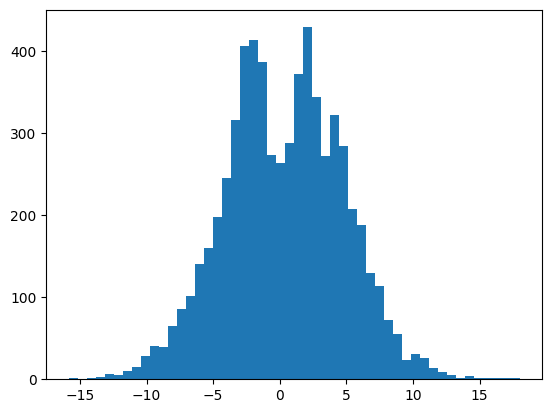

In [23]:
# hpreact is also toooo broad (-15 to 15)
plt.hist(hpreact.view(-1).tolist(), 50)

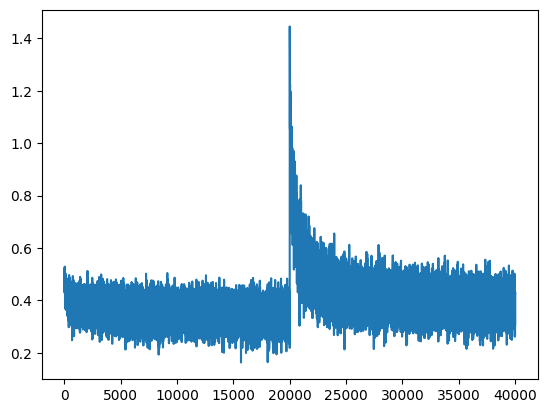

In [24]:
plt.plot(lossi)

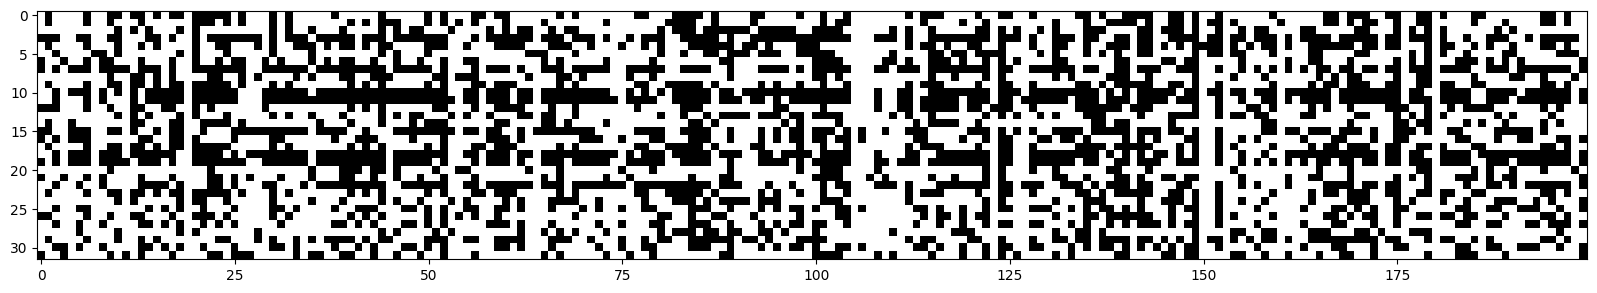

In [25]:
plt.figure(figsize = (20, 10))
plt.imshow(h.abs()>0.99, cmap = 'gray', interpolation = "nearest")





# here: we have some dead neurons (where the whole columns are white)

tensor(-0.0036) tensor(0.9977)
tensor(-0.0009) tensor(3.1162)


(array([2.10852499e-05, 7.02841663e-06, 1.40568333e-05, 2.81136665e-05,
        2.81136665e-05, 4.91989164e-05, 1.47596749e-04, 1.40568333e-04,
        2.31937749e-04, 4.63875498e-04, 7.73125830e-04, 1.25808658e-03,
        1.89064407e-03, 3.09250332e-03, 5.15885781e-03, 7.76640038e-03,
        1.16812284e-02, 1.76553826e-02, 2.58364595e-02, 3.73911765e-02,
        5.19189137e-02, 7.05020473e-02, 9.15872972e-02, 1.11730739e-01,
        1.29182298e-01, 1.38530092e-01, 1.38572262e-01, 1.28142092e-01,
        1.10423454e-01, 9.06033188e-02, 6.87589999e-02, 5.16096633e-02,
        3.61330899e-02, 2.47751686e-02, 1.78240646e-02, 1.14422623e-02,
        7.54149105e-03, 4.97611898e-03, 3.04330440e-03, 1.77818941e-03,
        1.22294449e-03, 6.46614330e-04, 4.77932331e-04, 2.45994582e-04,
        1.12454666e-04, 7.73125830e-05, 9.83978329e-05, 5.62273331e-05,
        1.40568333e-05, 2.10852499e-05]),
 array([-18.47448921, -17.76309143, -17.05169365, -16.34029587,
        -15.62889809, -14.9175

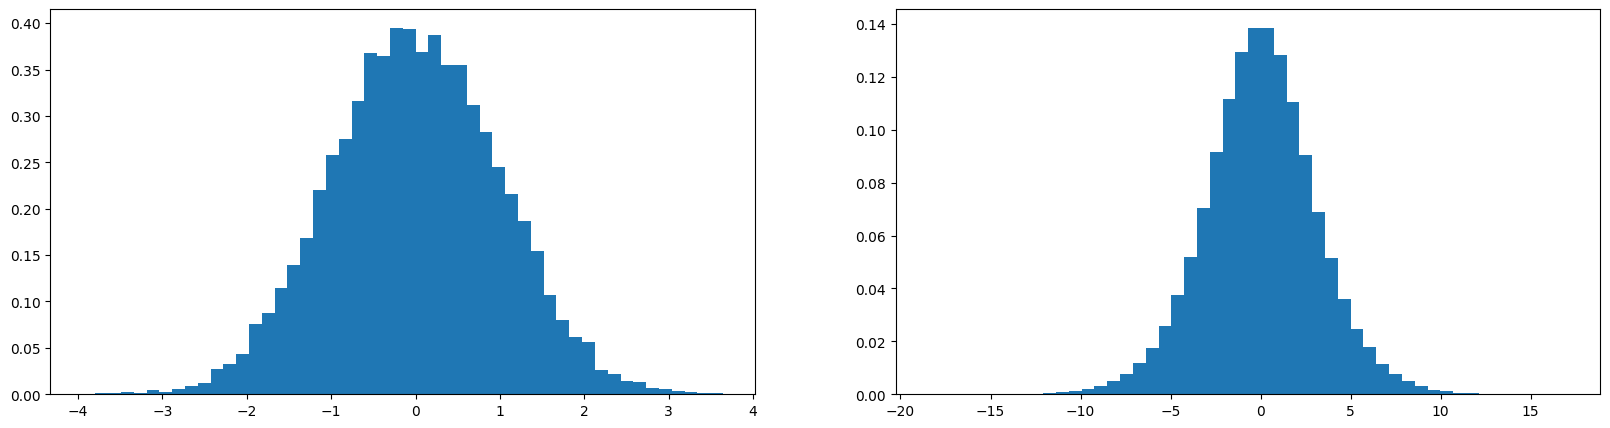

In [26]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) 
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True)




tensor(0.0079) tensor(0.9952)
tensor(-0.0493) tensor(15.7309)


(array([2.59100963e-06, 1.29550481e-06, 3.88651444e-06, 2.59100963e-06,
        6.47752407e-06, 1.68415626e-05, 2.85011059e-05, 4.14561541e-05,
        7.77302888e-05, 1.60642597e-04, 2.57805458e-04, 4.40471637e-04,
        7.57870316e-04, 1.30586885e-03, 2.01321448e-03, 3.26985415e-03,
        4.99676207e-03, 7.27296403e-03, 1.04858160e-02, 1.44241506e-02,
        1.88197984e-02, 2.27736791e-02, 2.57857278e-02, 2.69866608e-02,
        2.61795613e-02, 2.34486371e-02, 1.96411485e-02, 1.56302656e-02,
        1.13719413e-02, 8.04378939e-03, 5.47998536e-03, 3.61834495e-03,
        2.33061316e-03, 1.41339575e-03, 8.56328682e-04, 5.10428897e-04,
        2.96670602e-04, 1.47687549e-04, 8.80943274e-05, 5.18201926e-05,
        2.85011059e-05, 1.42505530e-05, 7.77302888e-06, 5.18201926e-06,
        1.29550481e-06, 1.29550481e-06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.29550481e-06]),
 array([-91.20495605, -87.3454567 , -83.48595734, -79.62645798,
        -75.76695862, -71.9074

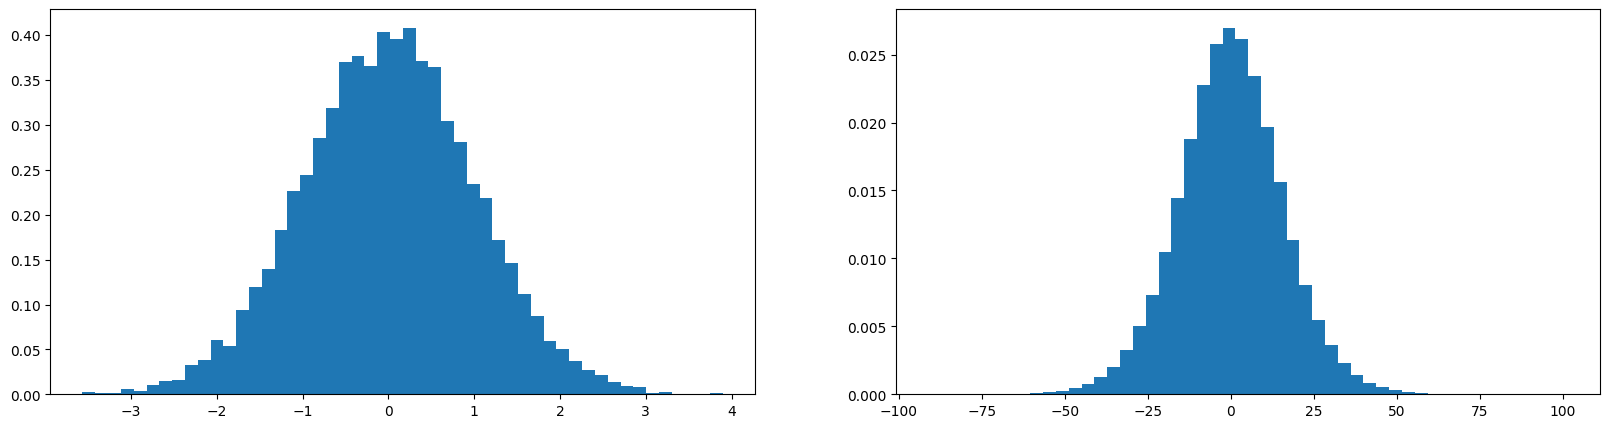

In [27]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True)




tensor(0.0041) tensor(1.0083)
tensor(0.0010) tensor(0.6384)


(array([1.06644912e-04, 2.48838128e-04, 2.13289824e-04, 4.62127951e-04,
        9.59804207e-04, 1.03090081e-03, 2.20399484e-03, 3.16379905e-03,
        4.97676255e-03, 8.88707599e-03, 1.45748046e-02, 2.27864628e-02,
        3.65792048e-02, 4.96609806e-02, 7.73886577e-02, 1.14429990e-01,
        1.64019874e-01, 2.29108819e-01, 3.08523730e-01, 3.96541331e-01,
        5.00982248e-01, 5.93443386e-01, 6.50853897e-01, 6.83558337e-01,
        6.61589485e-01, 5.89497524e-01, 5.06492235e-01, 4.06885887e-01,
        3.19934736e-01, 2.35152031e-01, 1.70596311e-01, 1.18802432e-01,
        8.21521304e-02, 5.31802627e-02, 3.70057844e-02, 2.41728467e-02,
        1.57123503e-02, 8.99372090e-03, 5.97211506e-03, 3.44818548e-03,
        1.84851181e-03, 1.06644912e-03, 8.53159295e-04, 7.82062687e-04,
        2.84386432e-04, 2.84386432e-04, 1.06644912e-04, 7.10966079e-05,
        3.55483039e-05, 3.55483039e-05]),
 array([-3.31177354, -3.17111985, -3.03046617, -2.88981248, -2.74915879,
        -2.60850511, 

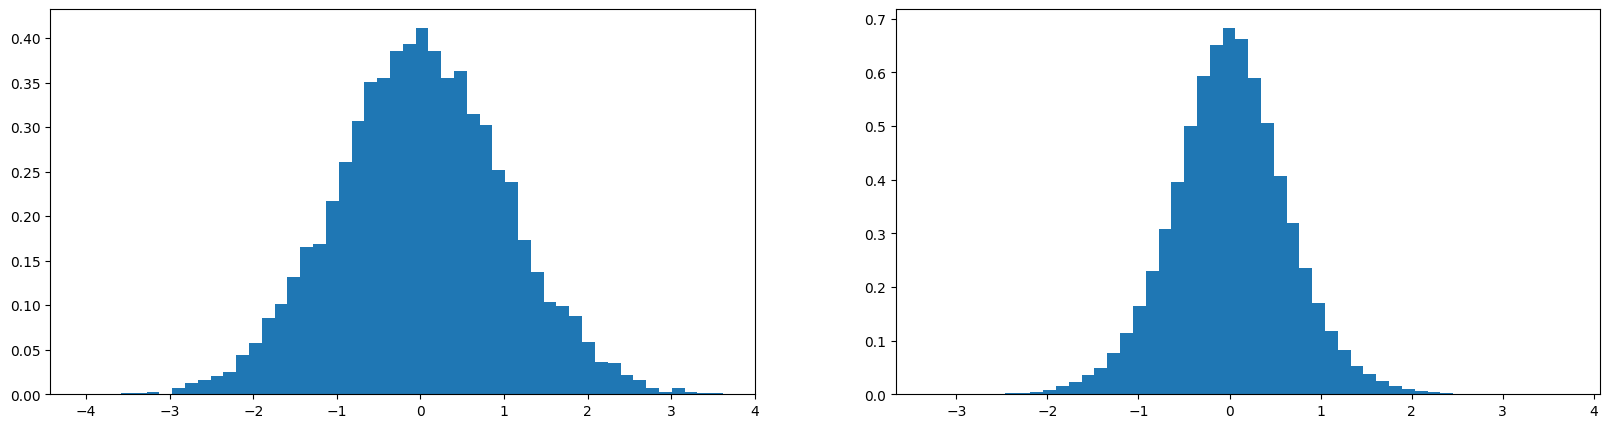

In [28]:
# shrik 
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 0.2
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density = True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density = True)




In [29]:
torch.randn(10000)*0.2

tensor([-0.0147, -0.2899,  0.1288,  ..., -0.1093,  0.1325,  0.1592])

In [30]:
n_embd * block_size

30

In [31]:
(torch.randn(10000)*0.2).std

<function Tensor.std>

In [32]:
# torch.nn.tanh recommendation

In [33]:
5/3 / (30**0.5)

0.3042903097250923

## Batch Normalization 



In [34]:
# 
n_embd = 10 
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden, generator=g) 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
# make it small, but not 0
# b2 = torch.randn(vocab_size, generator=g)
b2 = torch.randn(vocab_size, generator=g) * 0

# baatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True


12097


In [35]:
for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # linear layer
    # hidden layer pre-activation
    hpreact = embcat @ W1 
    #+ b1 b1 is wasted here, they will be subtracted out by bnmeani, and does not have effect
    # so b1 can be completely ignored. 
    
    # BatchNorm layer **************************** Here !!!!
    # -------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # offsetting by bnstdi and bnbias
    
     # center the batch using Gaussian
    
    
    with torch.no_grad():
        # inferences 
        # on top of that, we will calculate mean and varaiance 
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)
    

    for p in parameters:
        p.grad = None
    loss.backward()


    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 100 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
  

      0/  20000: 3.3147
    100/  20000: 2.4222
    200/  20000: 2.8362
    300/  20000: 2.5838
    400/  20000: 2.5099
    500/  20000: 2.7987
    600/  20000: 2.4470
    700/  20000: 2.4766
    800/  20000: 2.3610
    900/  20000: 2.1361
   1000/  20000: 2.1945
   1100/  20000: 2.2817
   1200/  20000: 2.6710
   1300/  20000: 2.7380
   1400/  20000: 2.3078
   1500/  20000: 2.3958
   1600/  20000: 2.6015
   1700/  20000: 2.3745
   1800/  20000: 2.3172
   1900/  20000: 2.3646
   2000/  20000: 2.3061
   2100/  20000: 2.4367
   2200/  20000: 1.9582
   2300/  20000: 2.4397
   2400/  20000: 2.8702
   2500/  20000: 2.3725
   2600/  20000: 2.3520
   2700/  20000: 2.1794
   2800/  20000: 2.2166
   2900/  20000: 2.2390
   3000/  20000: 2.2337
   3100/  20000: 2.5820
   3200/  20000: 2.2044
   3300/  20000: 2.2671
   3400/  20000: 2.2901
   3500/  20000: 2.4187
   3600/  20000: 2.0603
   3700/  20000: 2.1360
   3800/  20000: 2.3896
   3900/  20000: 2.3852
   4000/  20000: 2.1661
   4100/  20000:

In [36]:
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [37]:
# this decorator disables gradient tracking
@torch.no_grad() 
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
    emb = C[x]
    # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # batch normalization 
#     hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True))/ hpreact.std(0, keepdim = True)
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2122321128845215
val 2.229529619216919


## ResNET

mostly words in videos

## Summary and final version 

### some variations are followed later

In [142]:
class Linear:
      def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
      
      def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
              self.out += self.bias
        return self.out
    
      def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
        xmean = x.mean(0, keepdim=True) # batch mean
        xvar = x.var(0, keepdim=True) # batch variance
    else:
        xmean = self.running_mean
        xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
        with torch.no_grad():
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
      def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
      def parameters(self):
        return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
    layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]


# number of parameters in total
print(sum(p.nelement() for p in parameters)) 
for p in parameters:
    p.requires_grad = True

47024


In [143]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  

    emb = C[Xb] 
    
    # concatenate the vectors
    
    x = emb.view(emb.shape[0], -1) 
    for layer in layers:
        x = layer(x)
        loss = F.cross_entropy(x, Yb) 
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad() 
        
        # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 200 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        # AFTER_DEBUG: would take out obviously to run full optimization
        break

      0/ 200000: 3.2870
    200/ 200000: 2.6686
    400/ 200000: 2.4984
    600/ 200000: 2.5738
    800/ 200000: 2.5789
   1000/ 200000: 2.2807


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

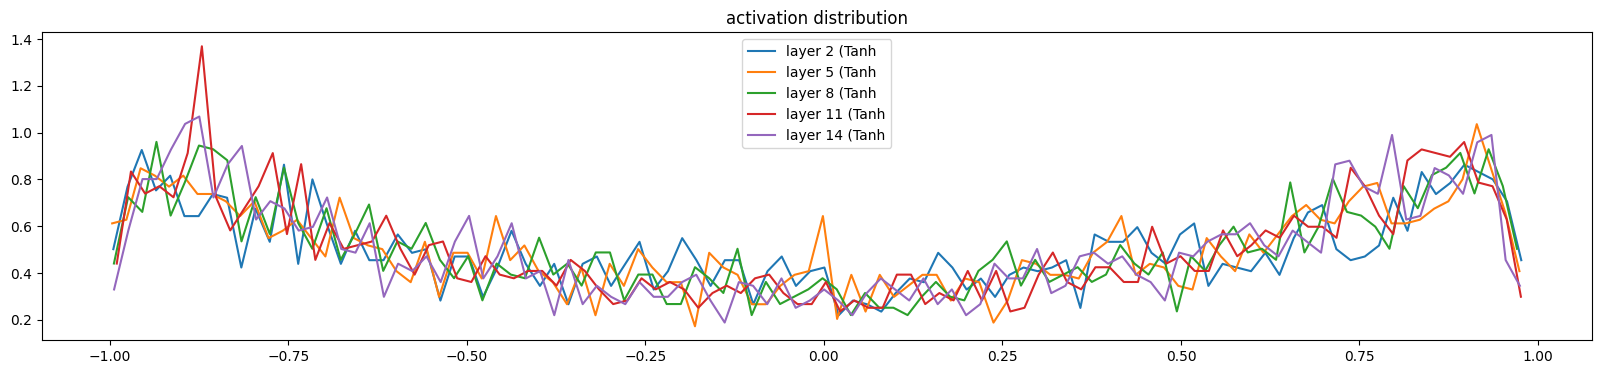

In [144]:
# visualize histograms
# width and height of the plot
plt.figure(figsize=(20, 4)) 
legends = []
# exclude the output layer
for i, layer in enumerate(layers[:-1]): 
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 2.640702e-03
layer 5 (      Tanh): mean -0.000000, std 2.245584e-03
layer 8 (      Tanh): mean -0.000000, std 2.045742e-03
layer 11 (      Tanh): mean -0.000000, std 1.983133e-03
layer 14 (      Tanh): mean -0.000000, std 1.952381e-03


Text(0.5, 1.0, 'gradient distribution')

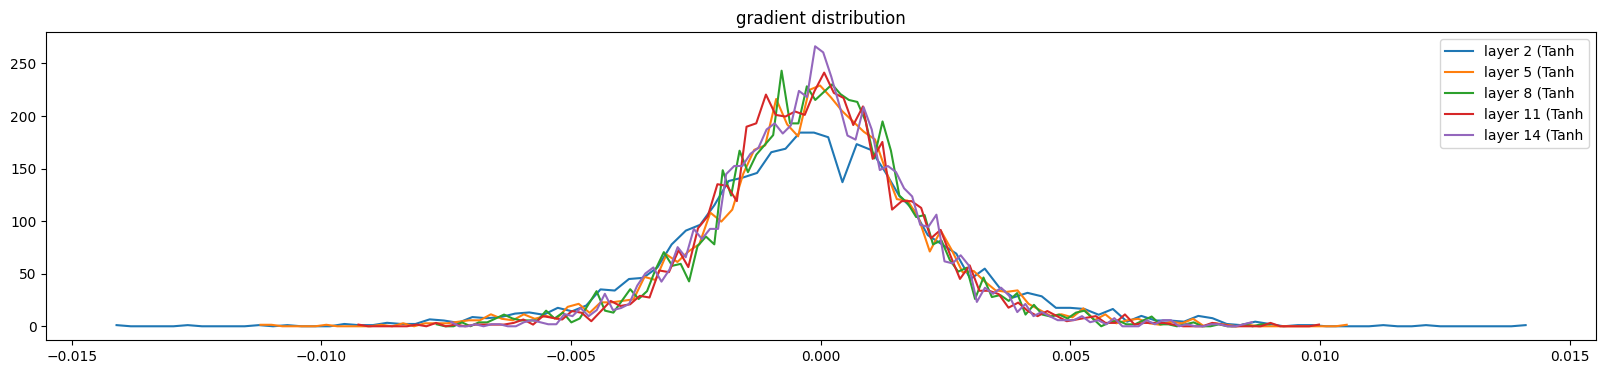

In [145]:
# visualize histograms
# width and height of the plot
plt.figure(figsize=(20, 4))
legends = []


# no output layer
for i, layer in enumerate(layers[:-1]): 
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.020530e-03 | grad:data ratio 8.012626e-03
weight  (30, 100) | mean +0.000246 | std 9.241071e-03 | grad:data ratio 4.881088e-02
weight (100, 100) | mean +0.000113 | std 7.132875e-03 | grad:data ratio 6.964615e-02
weight (100, 100) | mean -0.000086 | std 6.234302e-03 | grad:data ratio 6.073738e-02
weight (100, 100) | mean +0.000052 | std 5.742183e-03 | grad:data ratio 5.631479e-02
weight (100, 100) | mean +0.000032 | std 5.672202e-03 | grad:data ratio 5.570123e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


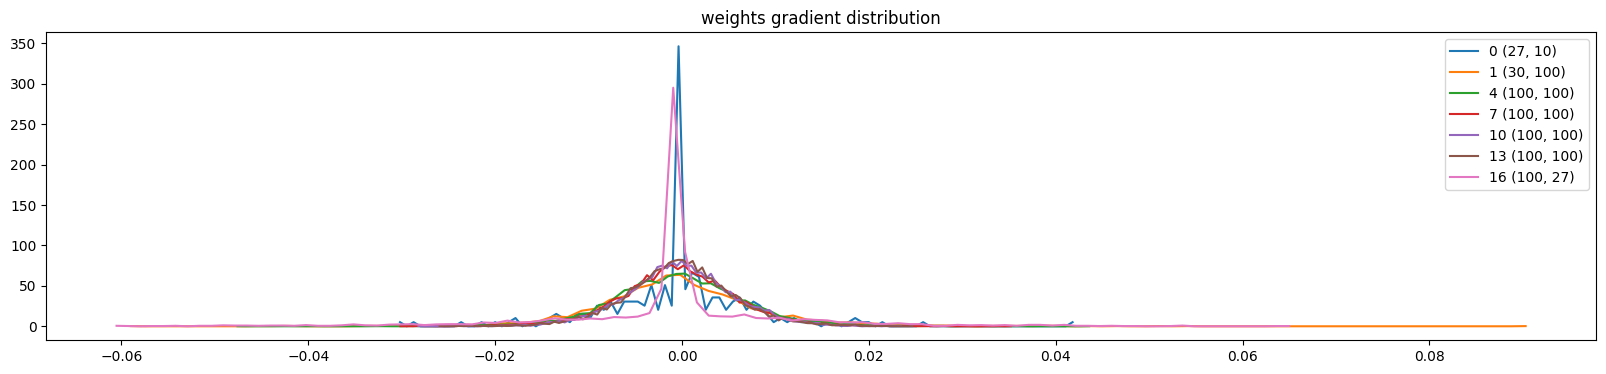

In [146]:
# visualize histograms
plt.figure(figsize=(20, 4)) 
# width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

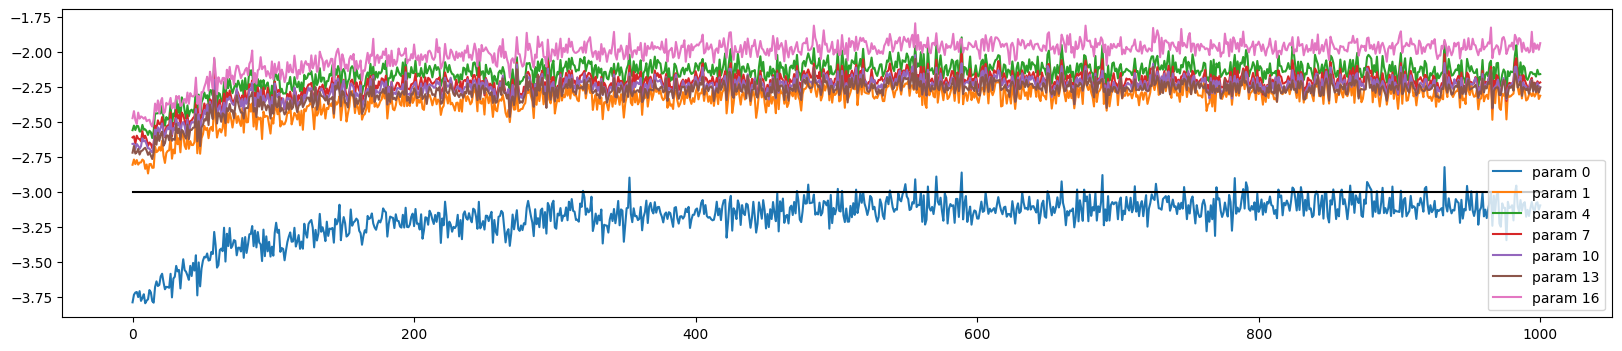

In [147]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [148]:
# this decorator disables gradient tracking
@torch.no_grad() 
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
    # (N, block_size, n_embd)
    emb = C[x] 
    # concat into (N, block_size * n_embd)
    x = emb.view(emb.shape[0], -1) 
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
      layer.training = False
split_loss('train')
split_loss('val')

train 2.4002976417541504
val 2.3982467651367188


In [149]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mria.
mmyan.
seelendhnyal.
rethrsjendrleg.
ade.
kdieliin.
miloen.
ekeisean.
xarlelleimhlara.
noshdh.
rgshiries.
kin.
reneliqxnthacfiu.
zayvde.
jymeli.
ehs.
kay.
mistoyan.
hal.
salyansuiezajelveu.


### Summary with variations

# With Diagonasis tools to see if the nerual networks are functioning well

# ratios and graphs followed

### performance wise, our bottleneck is at the pair-length 

In [109]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.rand((fan_in, fan_out), generator = g) /fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x@self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out 
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [110]:
class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True  
        # parameters 
        # trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers 
        #trained with a running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim) 
  
    def __call__(self, x):
        # calculate forward
        if self.training:
            # batch mean
            xmean = x.mean(0, keepdim=True) 
            # batch variance
            xvar = x.var(0, keepdim=True) 
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # normalize to unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) 
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [111]:
n_embd = 10 
# dimensionality of the character embedding vectors
n_hidden = 100 
# the number of neurons in the hidden layer 
g = torch.Generator().manual_seed(2147483647) 

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear( n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear( n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

In [112]:
with torch.no_grad():
    # last layer
    # make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3# 3 # 5/3  # 1 5/3 comes from pytorch

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [113]:
max_steps = 200000
batch_size = 32
lossi = []
# update to date ratio
ud = []

for i in range(max_steps):
  
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  

    emb = C[Xb] 
    # concatenate the vectors
    x = emb.view(emb.shape[0], -1) 
    for layer in layers:
        x = layer(x)
        loss = F.cross_entropy(x, Yb) # loss function
  
    # backward pass
    for layer in layers:
        layer.out.retain_grad() 
        # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 200 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        #AFTER_DEBUG: would take out obviously to run full optimization
        break 

      0/ 200000: 3.2958
    200/ 200000: 2.9232
    400/ 200000: 2.9266
    600/ 200000: 2.8039
    800/ 200000: 2.8810
   1000/ 200000: 2.6678


layer 2 (      Tanh): mean -0.06, std 0.68, saturated: 0.00%
layer 5 (      Tanh): mean -0.07, std 0.71, saturated: 0.00%
layer 8 (      Tanh): mean -0.07, std 0.72, saturated: 0.00%
layer 11 (      Tanh): mean -0.08, std 0.72, saturated: 0.00%
layer 14 (      Tanh): mean -0.08, std 0.72, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

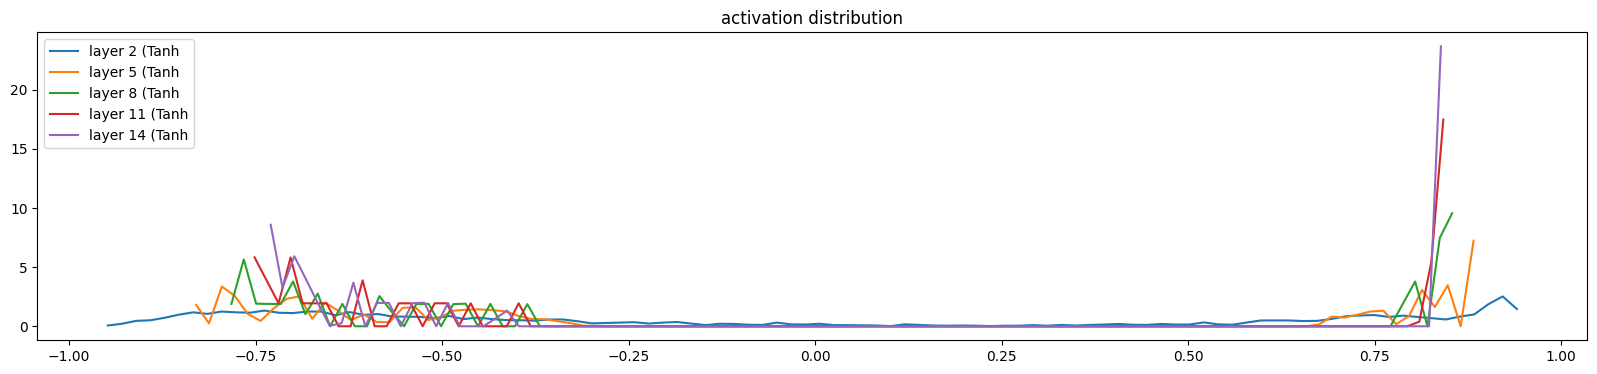

In [114]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 1.831842e-04
layer 5 (      Tanh): mean +0.000000, std 1.498482e-04
layer 8 (      Tanh): mean -0.000000, std 1.422603e-04
layer 11 (      Tanh): mean -0.000000, std 1.521605e-04
layer 14 (      Tanh): mean +0.000000, std 2.234980e-04


Text(0.5, 1.0, 'gradient distribution')

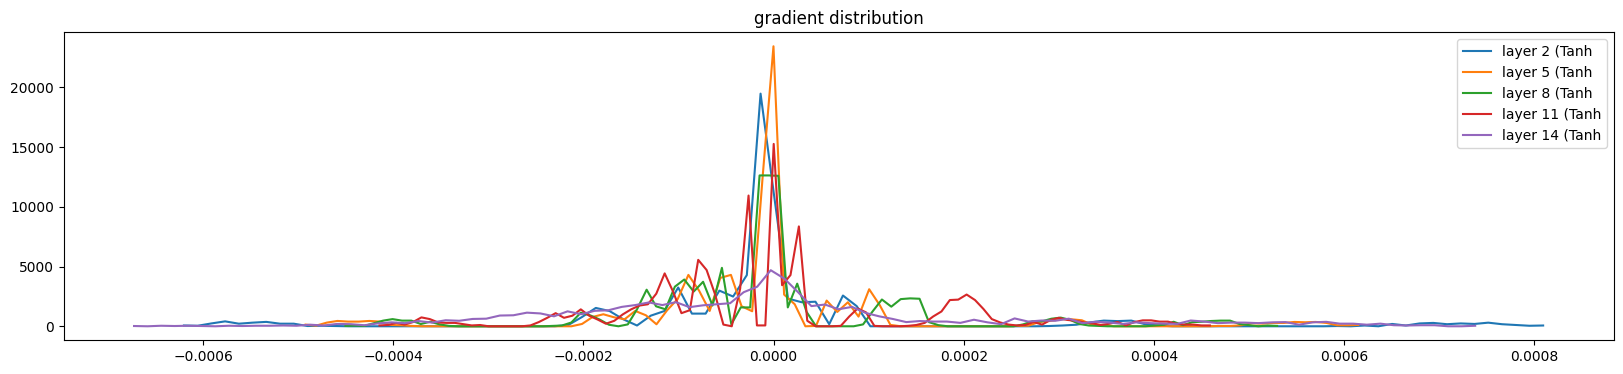

In [115]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 2.287029e-03 | grad:data ratio 2.285169e-03
weight  (30, 100) | mean +0.000008 | std 4.016900e-04 | grad:data ratio 4.477509e-03
weight (100, 100) | mean +0.000000 | std 2.207511e-05 | grad:data ratio 4.578526e-04
weight (100, 100) | mean +0.000000 | std 1.245422e-06 | grad:data ratio 2.592636e-05
weight (100, 100) | mean +0.000000 | std 8.064328e-08 | grad:data ratio 1.671801e-06
weight (100, 100) | mean +0.000000 | std 6.543210e-09 | grad:data ratio 1.364208e-07
weight  (100, 27) | mean +0.000000 | std 3.229606e-07 | grad:data ratio 6.659568e-06


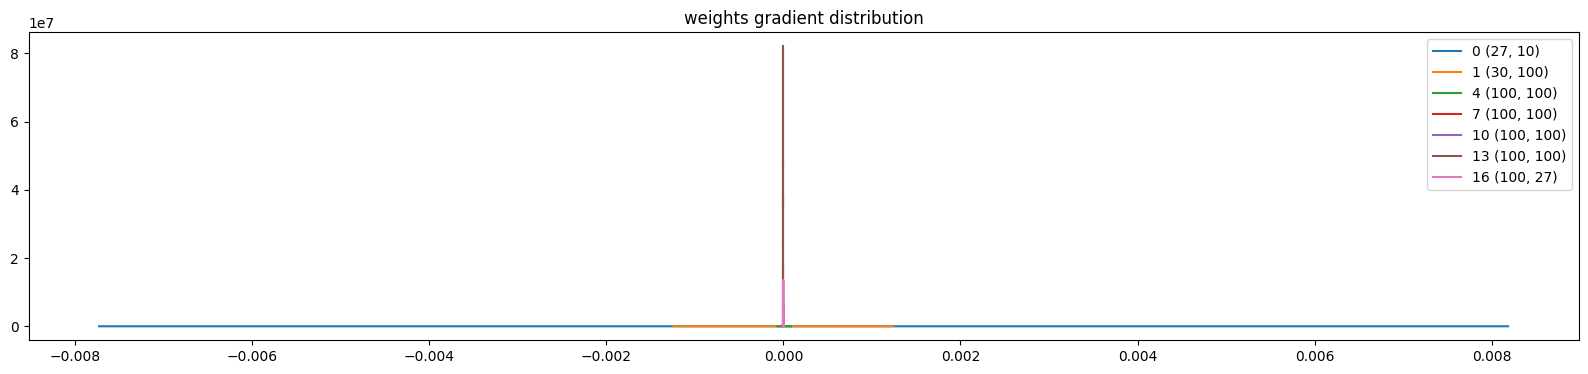

In [116]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

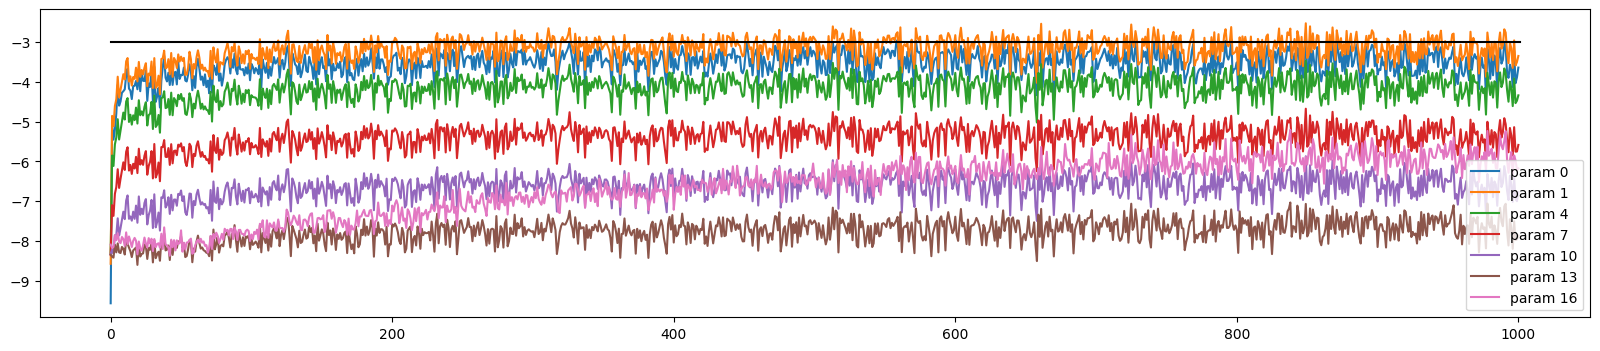

In [117]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [118]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 2.734017848968506
val 2.728424310684204


In [119]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

erraaimyaaliee.
mnd.
ryal.
rethrs.
ejdrleg.
azeeed.
eliiheli.
realeieineananarneltziohltea.
n.
sadbvrgahi.
ies.
kj.
jr.
jel.
rxntpuofou.
amyed.
ryy.
rufmehs.
rmaja.
sklyaa.


# Bonus  (Later)